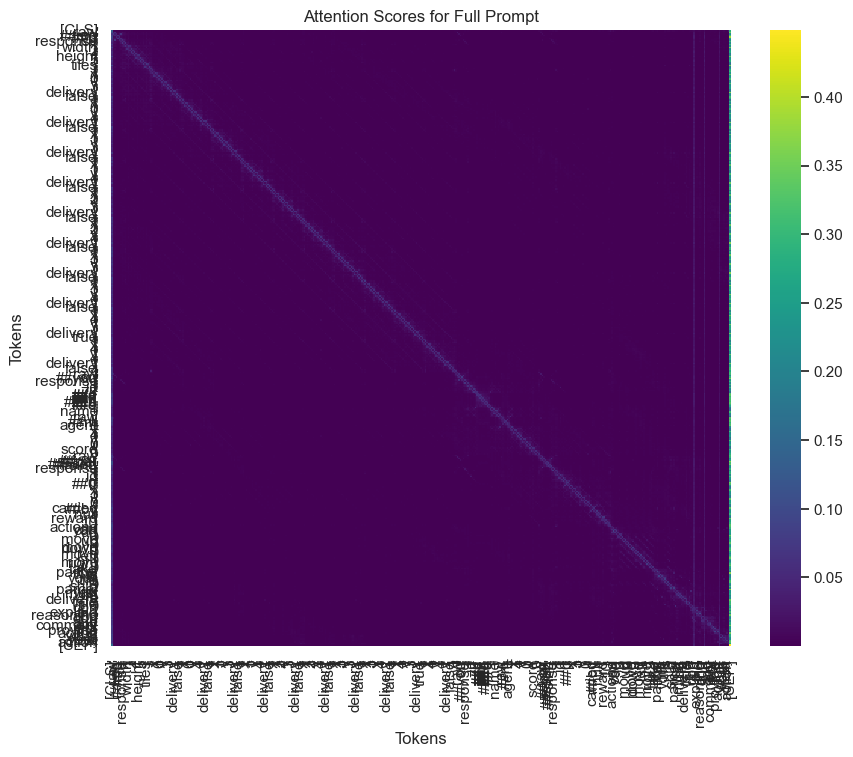

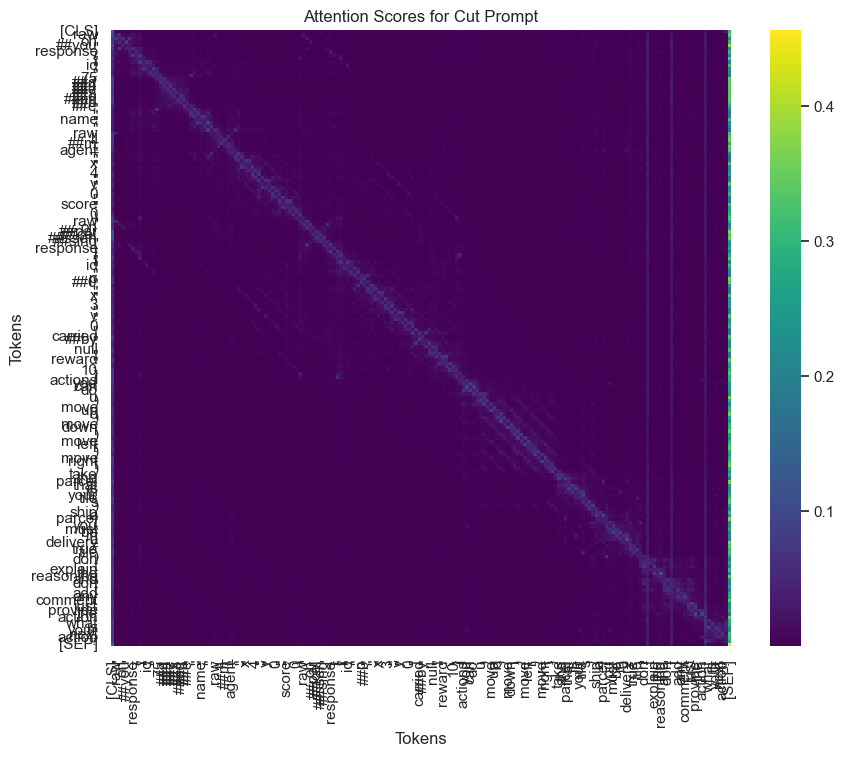

TypeError: list indices must be integers or slices, not list

In [5]:
import torch
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import seaborn as sns

# Load the text files
with open('promptFull.txt', 'r') as file:
    prompt_full = file.read()

with open('prompt.txt', 'r') as file:
    prompt_cut = file.read()

# Load a pre-trained model and tokenizer
model_name = 'bert-base-uncased'  # You can choose any model you prefer
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_attentions=True)

# Tokenize the prompts
inputs_full = tokenizer(prompt_full, return_tensors='pt')
inputs_cut = tokenizer(prompt_cut, return_tensors='pt')

# Get the attention scores
with torch.no_grad():
    outputs_full = model(**inputs_full)
    outputs_cut = model(**inputs_cut)

# Extract attention scores
attentions_full = outputs_full.attentions
attentions_cut = outputs_cut.attentions

# Average the attention scores across all heads, layers, and batch
avg_attentions_full = torch.mean(torch.stack(attentions_full), dim=(0, 1, 2)).squeeze()
avg_attentions_cut = torch.mean(torch.stack(attentions_cut), dim=(0, 1, 2)).squeeze()

# Plot the attention scores
def plot_attention(attentions, tokens, title):
    sns.set(style='whitegrid')
    plt.figure(figsize=(10, 8))
    sns.heatmap(attentions, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    plt.title(title)
    plt.xlabel('Tokens')
    plt.ylabel('Tokens')
    plt.show()

# Get the tokens
tokens_full = tokenizer.convert_ids_to_tokens(inputs_full['input_ids'].squeeze())
tokens_cut = tokenizer.convert_ids_to_tokens(inputs_cut['input_ids'].squeeze())

# Plot the attention for full and cut prompts
plot_attention(avg_attentions_full, tokens_full, 'Attention Scores for Full Prompt')
plot_attention(avg_attentions_cut, tokens_cut, 'Attention Scores for Cut Prompt')

# Highlight the tokens with the highest attention scores
def highlight_top_tokens(attentions, tokens, top_n=5):
    top_indices = torch.topk(attentions, top_n).indices.tolist()
    highlighted_tokens = [tokens[i] for i in top_indices]
    return highlighted_tokens

top_tokens_full = highlight_top_tokens(avg_attentions_full, tokens_full)
top_tokens_cut = highlight_top_tokens(avg_attentions_cut, tokens_cut)

print("Top tokens with highest attention in full prompt:", top_tokens_full)
print("Top tokens with highest attention in cut prompt:", top_tokens_cut)